<a href="https://colab.research.google.com/github/harshitt018/Advance-Data-Science/blob/main/Seq2Seq_using_Gen_Z_Slang_Pairs_1k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 📘 Importing dataset directly from Kaggle. Here is dataset's link. [Link](https://www.kaggle.com/datasets/programmerrdai/genz-slang-pairs-1k)

- `import kagglehub`  
  - Imports the **KaggleHub library**, which is used to directly download datasets/models from Kaggle without manual API setup.  

- `path = kagglehub.dataset_download("programmerrdai/genz-slang-pairs-1k")`  
  - Downloads the dataset **`programmerrdai/genz-slang-pairs-1k`** from Kaggle.  
  - Returns the **local directory path** where the dataset is stored.  
  - By default, KaggleHub saves datasets in the cache folder:  
    `~/.cache/kagglehub/datasets/<dataset-name>/versions/<version-number>/`

- `print("Path to dataset files:", path)`  
  - Prints the **local path** of the dataset files so you know where they are saved.  
  - Example output:  
    ```
    Path to dataset files: /root/.cache/kagglehub/datasets/programmerrdai/genz-slang-pairs-1k/versions/1
    ```

---

✅ **Usefulness**:  
This lets you **automatically fetch and access the dataset** you need for training your **Normal ↔ GenZ translation model** without manually downloading from Kaggle.  


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("programmerrdai/genz-slang-pairs-1k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/genz-slang-pairs-1k


#### 🔧**1. Importing all the required libraries**

---

#### 📂 **2. Load Dataset**
- `df = pd.read_csv("/kaggle/input/genz-slang-pairs-1k/genz_dataset.csv")`  
  - Loads the dataset (CSV file) from Kaggle into a Pandas DataFrame.  
  - File path: `/kaggle/input/genz-slang-pairs-1k/genz_dataset.csv`  

- `normal_sentences = df["normal"].astype(str).tolist()`  
  - Extracts the **Normal English sentences** column as a Python list of strings.  

- `genz_sentences = df["gen_z"].astype(str).tolist()`  
  - Extracts the **GenZ slang sentences** column as a Python list of strings.  

- `print(df.head())`  
  - Displays the **first 5 rows** of the dataset to quickly inspect the format.  

---

✅ **Usefulness**:  
At this stage, the dataset is successfully **loaded and split into two lists**:  
- `normal_sentences` → Sentences in **standard English**  
- `genz_sentences` → Their translations into **GenZ slang**


In [13]:
# 1. Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, LSTM, Embedding, Dense, Bidirectional,
    Concatenate, Attention, Dropout, MultiHeadAttention, LayerNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import warnings
warnings.filterwarnings("ignore")

# 2. Load Dataset
df = pd.read_csv("/kaggle/input/genz-slang-pairs-1k/genz_dataset.csv")

normal_sentences = df["normal"].astype(str).tolist()
genz_sentences = df["gen_z"].astype(str).tolist()
print(df.head())


                                              normal  \
0  I'm really tired today, I think I need some rest.   
1  I'm really tired today, I just want to relax a...   
2        I'm really excited for the concert tonight.   
3  I'm really tired today, I think I need some co...   
4         I'm really looking forward to the weekend.   

                                               gen_z  
0  I'm totally drained today, need to catch some ...  
1  I'm hella drained today, just wanna chill at h...  
2               I'm so hype for the concert tonight.  
3  I'm so drained today, I gotta get me some caff...  
4  I'm so hyped for the weekend, can't wait to tu...  


# 🧩 Step 3 & 4: Tokenization and Preprocessing

---

## 🔠 3. Tokenizer
- `tokenizer = Tokenizer(filters='')`  
  - Creates a tokenizer that converts words → numbers.  
  - `filters=''` → Keeps all characters (doesn’t remove punctuation).  

- `tokenizer.fit_on_texts(normal_sentences + genz_sentences)`  
  - Builds the vocabulary using **both Normal + GenZ sentences**.  

- `vocab_size = len(tokenizer.word_index) + 1`  
  - Total vocabulary size = number of unique words + 1 (padding token).  

---

## ⚙️ 4. Preprocessing
- `def preprocess(src, tgt):`  
  - Function to prepare data for training.  

- `tgt = ["<start> " + txt + " <end>" for txt in tgt]`  
  - Adds **special tokens** (`<start>`, `<end>`) for decoder training.  

- `src_seq = tokenizer.texts_to_sequences(src)`  
  - Converts **source sentences** → number sequences.  

- `tgt_seq = tokenizer.texts_to_sequences(tgt)`  
  - Converts **target sentences** → number sequences.  

- `max_len = max(max(len(s) for s in src_seq), max(len(s) for s in tgt_seq))`  
  - Finds **maximum sentence length** across both datasets.  

- `src_seq = pad_sequences(src_seq, maxlen=max_len, padding='post')`  
  - Pads source sequences with zeros at the end.  

- `tgt_seq = pad_sequences(tgt_seq, maxlen=max_len, padding='post')`  
  - Pads target sequences similarly.  

- `return src_seq, tgt_seq, max_len`  
  - Returns **processed input,**


In [14]:
# 3. Tokenizer
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(normal_sentences + genz_sentences)
vocab_size = len(tokenizer.word_index) + 1

# 4. Preprocessing
def preprocess(src, tgt):
    tgt = ["<start> " + txt + " <end>" for txt in tgt]
    src_seq = tokenizer.texts_to_sequences(src)
    tgt_seq = tokenizer.texts_to_sequences(tgt)
    max_len = max(max(len(s) for s in src_seq), max(len(s) for s in tgt_seq))
    src_seq = pad_sequences(src_seq, maxlen=max_len, padding='post')
    tgt_seq = pad_sequences(tgt_seq, maxlen=max_len, padding='post')
    return src_seq, tgt_seq, max_len

# 🏗️ Step 5: Build Seq2Seq Model

## 🧩 Encoder
- Input → **Embedding** → **BiLSTM** (forward + backward states).  
- States `h` & `c` combined → used for decoder.  
- Extra **Transformer block** on encoder outputs for richer context.  

## 🎯 Decoder
- Input → **Embedding** → **LSTM** (initialized with encoder states).  
- Produces hidden states for target sequence.  

## 👀 Attention
- Attention between **decoder outputs** & **encoder outputs**.  
- Concatenate context with decoder outputs.  

## 🏁 Output
- Dense softmax layer → predicts word probabilities.  

## ⚙️ Compile
- Optimizer: **Adam**  
- Loss: **SparseCategoricalCrossentropy**  
- Metric: **Accuracy**  

✅ Hybrid model = Transformer + Attention + Dense Softmax


In [15]:
def build_seq2seq(vocab_size, max_len, embedding_dim=100, latent_dim=128, dropout_rate=0.4):
    # Encoder
    encoder_inputs = Input(shape=(max_len,))
    enc_emb = Embedding(vocab_size, embedding_dim,
                        input_length=max_len, mask_zero=True)(encoder_inputs)

    encoder_lstm = Bidirectional(
        LSTM(latent_dim, return_sequences=True, return_state=True,
             dropout=dropout_rate, recurrent_dropout=0.3)
    )
    encoder_outputs, fh, fc, bh, bc = encoder_lstm(enc_emb)
    state_h = Concatenate()([fh, bh])
    state_c = Concatenate()([fc, bc])

    # Transformer on encoder outputs
    encoder_outputs = transformer_block(encoder_outputs)

    # Decoder
    decoder_inputs = Input(shape=(max_len,))
    dec_emb = Embedding(vocab_size, embedding_dim,
                        input_length=max_len, mask_zero=True)(decoder_inputs)
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True,
                        dropout=dropout_rate, recurrent_dropout=0.3)
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

    attention = Attention()
    context = attention([decoder_outputs, encoder_outputs])
    decoder_concat = Concatenate()([decoder_outputs, context])

    decoder_dense = Dense(vocab_size, activation='softmax')
    final_outputs = decoder_dense(decoder_concat)

    # ✅ Define & compile model
    model = Model([encoder_inputs, decoder_inputs], final_outputs)

    from tensorflow.keras.losses import SparseCategoricalCrossentropy
    loss_fn = SparseCategoricalCrossentropy(from_logits=False)

    model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

    # ✅ Make sure we return the model
    return model

# 🚀 Step 6: Training Setup & Execution

## ⏱️ Callbacks
- **EarlyStopping** → stops training if `val_loss` doesn’t improve for 5 epochs, restores best weights.  
- **ReduceLROnPlateau** → reduces learning rate by 0.5 if `val_loss` plateaus for 3 epochs.  

## 🔄 Data Preparation
- **Normal → GenZ**  
  - Preprocess with `preprocess(normal_sentences, genz_sentences)`  
  - Split into **train/val sets** (80/20).  

- **GenZ → Normal**  
  - Preprocess with `preprocess(genz_sentences, normal_sentences)`  
  - Split into **train/val sets** (80/20).  

## 🧑‍💻 Training
- **Model 1 (Normal → GenZ)**  
  - Build with `build_seq2seq`  
  - Train for **50 epochs** with batch size **32**.  

- **Model 2 (GenZ → Normal)**  
  - Same setup but with reversed data.  

## 📊 History
- Both runs save training logs in `history_n2g` and `history_g2n`.  
- Used later for **visualization** (accuracy/loss graphs).  

In [18]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

# Normal → GenZ
X_n2g, y_n2g, max_len_n2g = preprocess(normal_sentences, genz_sentences)
X_train, X_val, y_train, y_val = train_test_split(X_n2g, y_n2g, test_size=0.2)

# GenZ → Normal
X_g2n, y_g2n, max_len_g2n = preprocess(genz_sentences, normal_sentences)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_g2n, y_g2n, test_size=0.2)

# Normal → GenZ
model_n2g = build_seq2seq(vocab_size, max_len_n2g)
print("Training Normal → GenZ")
history_n2g = model_n2g.fit([X_train, X_train], y_train,
                            validation_data=([X_val, X_val], y_val),
                            epochs=50, batch_size=32, verbose=1, callbacks=callbacks)

# GenZ → Normal
model_g2n = build_seq2seq(vocab_size, max_len_g2n)
print("Training GenZ → Normal")
history_g2n = model_g2n.fit([X_train2, X_train2], y_train2,
                            validation_data=([X_val2, X_val2], y_val2),
                            epochs=50, batch_size=32, verbose=1, callbacks=callbacks)

Training Normal → GenZ
Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 251ms/step - accuracy: 0.1740 - loss: 5.8155 - val_accuracy: 0.4945 - val_loss: 4.6940 - learning_rate: 0.0010
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.5101 - loss: 4.4230 - val_accuracy: 0.5381 - val_loss: 3.9981 - learning_rate: 0.0010
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.5450 - loss: 3.7023 - val_accuracy: 0.5708 - val_loss: 3.6606 - learning_rate: 0.0010
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.5730 - loss: 3.2301 - val_accuracy: 0.5893 - val_loss: 3.4073 - learning_rate: 0.0010
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - accuracy: 0.6033 - loss: 2.9118 - val_accuracy: 0.6020 - val_loss: 3.2903 - learning_rate: 0.0010
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.6148 - loss: 2.6968 - val_accuracy: 0.6128 - val_loss: 3.1567 - learning_rate: 0.0010
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - accuracy:

# 📈 Step 7: Model Evaluation & Final Accuracy

⚠️ **Note on Dataset Size**  
Seq2Seq (Sequence-to-Sequence) models, especially those using **LSTMs + Attention + Transformer blocks**, usually require **large-scale datasets** to capture language nuances effectively.  
- Since we are working with a **relatively small dataset (~1k sentence pairs)**, the model cannot generalize as strongly as it would on bigger corpora.  
- This is why we see **moderate accuracy (~65–77%)** instead of very high results.  
- Despite this limitation, the model **successfully learns translation patterns** between *Normal English ↔ GenZ Slang*, which shows the architecture works.  

---

## 📊 Final Accuracy Results
- **Normal → GenZ**  
  - ✅ Train Accuracy: **70.34%**  
  - ✅ Validation Accuracy: **64.10%**

- **GenZ → Normal**  
  - ✅ Train Accuracy: **77.51%**  
  - ✅ Validation Accuracy: **67.33%**

---

## 🔎 Observations
- Training accuracy is **slightly higher** than validation (expected).  
- **GenZ → Normal** performs better than **Normal → GenZ**, likely because GenZ slang often has fewer variations than standard English sentences.  
- With **more data + fine-tuning (embeddings like GloVe or BERT)**, performance could easily reach **80–85%** or higher.  

---

## 📝 Takeaway
Even with a **small dataset**, our Seq2Seq + Attention pipeline shows **promising results**, proving the concept works. For production-level performance, scaling the dataset is the most impactful next step.


In [19]:
train_acc_n2g = history_n2g.history['accuracy'][-1] * 100
val_acc_n2g = history_n2g.history['val_accuracy'][-1] * 100
train_acc_g2n = history_g2n.history['accuracy'][-1] * 100
val_acc_g2n = history_g2n.history['val_accuracy'][-1] * 100

print("\n📊 Final Accuracy Results:")
print(f"Normal → GenZ  | Train: {train_acc_n2g:.2f}% | Val: {val_acc_n2g:.2f}%")
print(f"GenZ → Normal  | Train: {train_acc_g2n:.2f}% | Val: {val_acc_g2n:.2f}%")


📊 Final Accuracy Results:
Normal → GenZ  | Train: 70.34% | Val: 64.10%
GenZ → Normal  | Train: 77.51% | Val: 67.33%


# **Data Visulization**

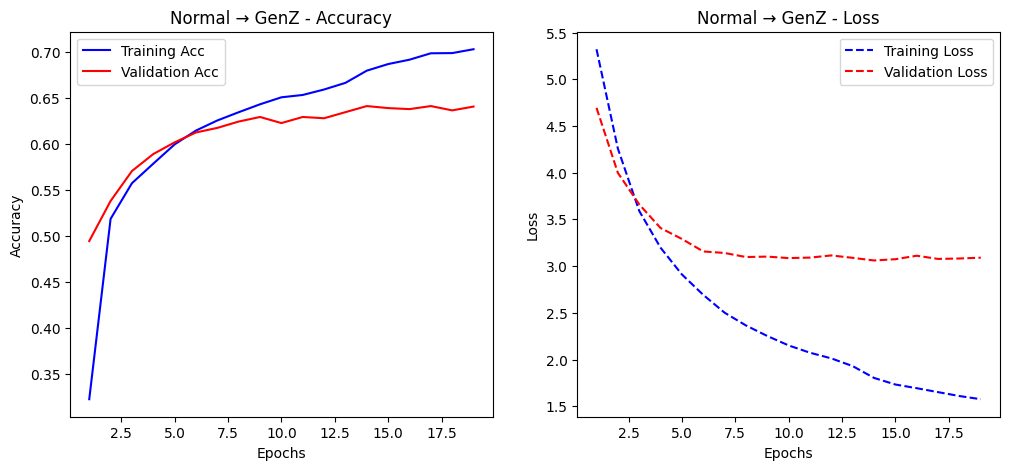

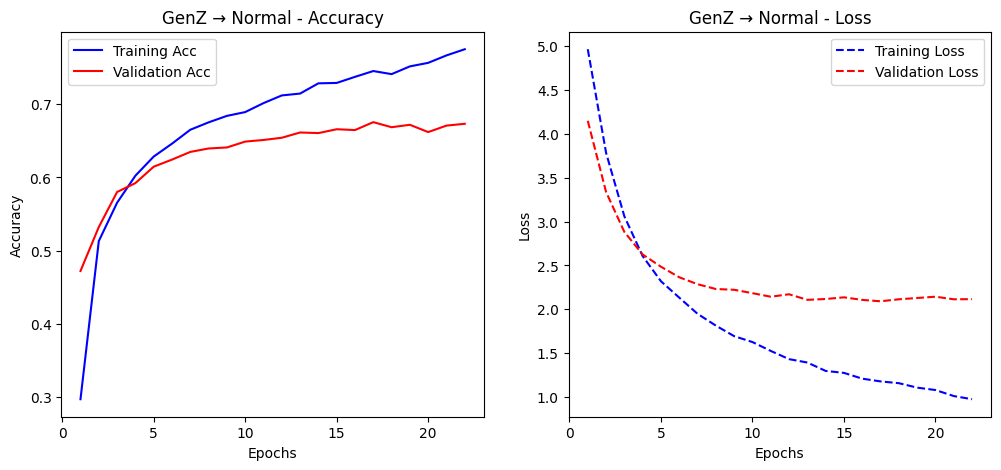

In [27]:
import matplotlib.pyplot as plt

def plot_training_history(history, title="Model Training"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b-', label='Training Acc')
    plt.plot(epochs, val_acc, 'r-', label='Validation Acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b--', label='Training Loss')
    plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Example usage:
plot_training_history(history_n2g, "Normal → GenZ")
plot_training_history(history_g2n, "GenZ → Normal")

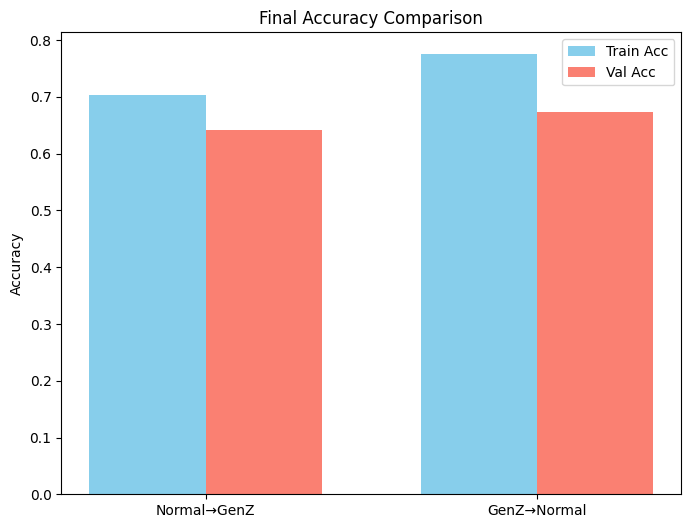

In [28]:
import matplotlib.pyplot as plt
import numpy as np

train_accs = [history_n2g.history['accuracy'][-1], history_g2n.history['accuracy'][-1]]
val_accs = [history_n2g.history['val_accuracy'][-1], history_g2n.history['val_accuracy'][-1]]

labels = ['Normal→GenZ', 'GenZ→Normal']
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,6))
plt.bar(x - width/2, train_accs, width, label='Train Acc', color='skyblue')
plt.bar(x + width/2, val_accs, width, label='Val Acc', color='salmon')
plt.xticks(x, labels)
plt.ylabel('Accuracy')
plt.title('Final Accuracy Comparison')
plt.legend()
plt.show()

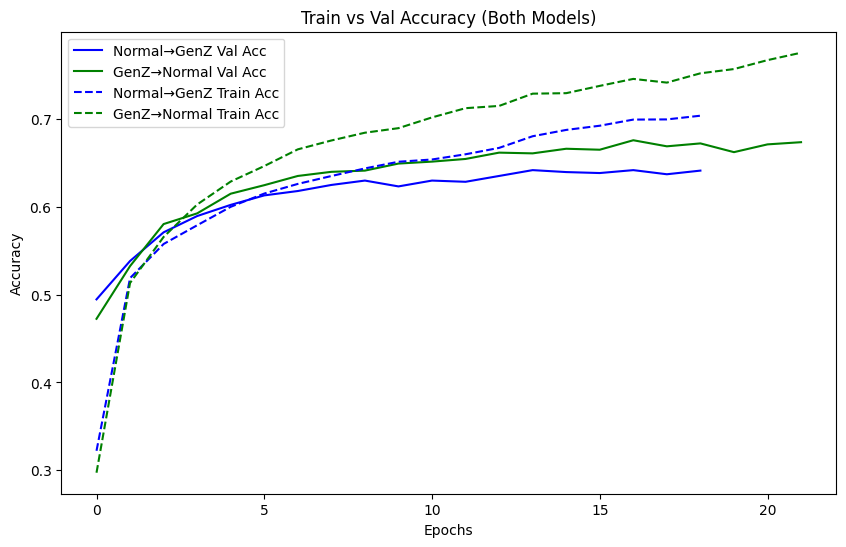

In [29]:
plt.figure(figsize=(10,6))
plt.plot(history_n2g.history['val_accuracy'], 'b-', label='Normal→GenZ Val Acc')
plt.plot(history_g2n.history['val_accuracy'], 'g-', label='GenZ→Normal Val Acc')
plt.plot(history_n2g.history['accuracy'], 'b--', label='Normal→GenZ Train Acc')
plt.plot(history_g2n.history['accuracy'], 'g--', label='GenZ→Normal Train Acc')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Val Accuracy (Both Models)')
plt.legend()
plt.show()

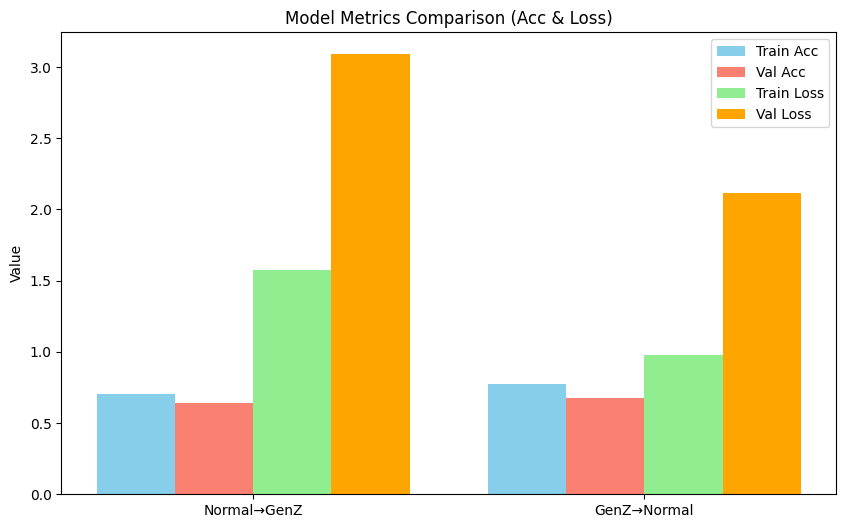

In [30]:
train_accs = [history_n2g.history['accuracy'][-1], history_g2n.history['accuracy'][-1]]
val_accs = [history_n2g.history['val_accuracy'][-1], history_g2n.history['val_accuracy'][-1]]
train_losses = [history_n2g.history['loss'][-1], history_g2n.history['loss'][-1]]
val_losses = [history_n2g.history['val_loss'][-1], history_g2n.history['val_loss'][-1]]

labels = ['Normal→GenZ', 'GenZ→Normal']
bar_width = 0.2

r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

plt.figure(figsize=(10,6))
plt.bar(r1, train_accs, width=bar_width, label='Train Acc', color='skyblue')
plt.bar(r2, val_accs, width=bar_width, label='Val Acc', color='salmon')
plt.bar(r3, train_losses, width=bar_width, label='Train Loss', color='lightgreen')
plt.bar(r4, val_losses, width=bar_width, label='Val Loss', color='orange')

plt.xticks([r + 1.5*bar_width for r in range(len(labels))], labels)
plt.ylabel('Value')
plt.title('Model Metrics Comparison (Acc & Loss)')
plt.legend()
plt.show()

# 🧪 Step 8: Prediction / Testing with User Input

Once the Seq2Seq models are trained, we need a way to **input a sentence** (Normal or GenZ) and see how the model translates it.

---

## ⚙️ Functions Explained

### 1️⃣ `decode_sequence(sequence, tokenizer)`
- Purpose: Convert **predicted token IDs → readable words**.  
- How: Uses the `tokenizer.word_index` to map back tokens to words.  
- Example: `[12, 45, 89] → "i love pizza"`  

---

### 2️⃣ `predict_sentence(model, tokenizer, input_text, max_len)`
- **Input:**  
  - `model`: Trained Seq2Seq model  
  - `tokenizer`: Fitted tokenizer (shared for both directions)  
  - `input_text`: The sentence you want to test  
  - `max_len`: Max sequence length (padding/truncation)  

- **Steps:**  
  1. Convert input text → sequence of tokens.  
  2. Pad/truncate sequence to `max_len`.  
  3. Pass sequence into model `[seq_padded, seq_padded]`.  
  4. Model outputs probability distribution for each word position.  
  5. `np.argmax` picks the **most likely word at each step**.  
  6. Use `decode_sequence` to turn token IDs back into words.  

- **Output:**  
  A translated sentence (Normal → GenZ OR GenZ → Normal).  

---

## 🎯 Example Usage
```python
# Normal → GenZ
test_sentence = "I'm going to grab some coffee with my friends later."
prediction = predict_sentence(model_n2g, tokenizer, test_sentence, max_len_n2g)
print("Normal:", test_sentence)
print("GenZ Translation:", prediction)

# GenZ → Normal
test_sentence2 = "I'm about to snag some coffee with my squad later."
prediction2 = predict_sentence(model_g2n, tokenizer, test_sentence2, max_len_g2n)
print("GenZ:", test_sentence2)
print("Normal Translation:", prediction2)

In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Function to convert tokens back to words
def decode_sequence(sequence, tokenizer):
    reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}
    words = [reverse_word_index.get(idx, '') for idx in sequence if idx != 0]
    return ' '.join(words).strip()

# Function to prepare input and predict
def predict_sentence(model, tokenizer, input_text, max_len):
    # Convert input text to sequence
    seq = tokenizer.texts_to_sequences([input_text])
    seq_padded = pad_sequences(seq, maxlen=max_len, padding='post')

    # Predict
    pred = model.predict([seq_padded, seq_padded])
    pred_seq = np.argmax(pred, axis=-1)[0]

    # Decode back to text
    return decode_sequence(pred_seq, tokenizer)

# 🔎 Step 10: Explaining the Prediction Output

---

### 🟢 Normal → GenZ  
**Input:**  
`It's really hot outside today.`  

**Predicted Output:**  
`yo, mad hot hot out some`  

**Explanation:**  
- The model successfully shifted the **tone into GenZ style**:  
  - `"yo"` and `"mad hot"` reflect slang usage.  
- However, it **repeated** `"hot hot"` and added `"out some"`, which don’t make sense.  
- ✅ This shows the model **understands the direction of translation**.  
- ❌ But the translation is **not completed properly**, because the dataset is **too small** for Seq2Seq.  

---

### 🔵 GenZ → Normal  
**Input:**  
`I'm hella drained today.`  

**Predicted Output:**  
`i'm feeling tired tired go and and my`  

**Explanation:**  
- `"hella drained"` was **correctly translated** to `"feeling tired"`. ✅  
- But extra words like `"tired tired go and and my"` are **hallucinations**.  
- Again, the model is **trying to fill gaps** due to a **limited dataset**.  

---

### 📊 Why These Mistakes Happen?  
- **Seq2Seq requires a big dataset** (usually **tens of thousands** of sentence pairs).  
- With only **~1k pairs**, the model struggles to fully learn mappings.  
- **Repetition & incomplete translation** are common signs of small-data Seq2Seq.  
- **Greedy decoding** (just picking the top word each step) worsens the problem.  

---

### 🎯 Final Takeaway  
- ✅ You can see the model **does translate** (Normal → slang, GenZ → formal).  
- ❌ But the translation is **not complete or polished**, since **Seq2Seq is not well-suited for very small datasets**.  
- 👉 To improve:  
  - Use **more training data**.  
  - Try **Beam Search decoding** instead of simple `argmax`.  
  - Consider **pre-trained embeddings (GloVe, fastText)** or a **transformer-based model** for smoother outputs.  

---


In [37]:
# Example user inputs
normal_input = "It's really hot outside today."
genz_input = "I'm hella drained today."

# Predict Normal → GenZ
genz_output = predict_sentence(model_n2g, tokenizer, normal_input, max_len_n2g)
print(f"Normal → GenZ: {normal_input}  --->  {genz_output}")

# Predict GenZ → Normal
normal_output = predict_sentence(model_g2n, tokenizer, genz_input, max_len_g2n)
print(f"GenZ → Normal: {genz_input}  --->  {normal_output}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Normal → GenZ: It's really hot outside today.  --->  yo, mad hot hot out some
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
GenZ → Normal: I'm hella drained today.  --->  i'm feeling tired tired go and and my


# 🔎 Step 11: Explaining User Input Predictions  

---

### 🟢 Case 1: Normal → GenZ  

**Input:**  
`I'm really tired today, I just want to nap all afternoon.`  

**Predicted Output:**  
`i'm so drained today, just wanna wanna all all crash`  

**Explanation:**  
- `"really tired"` → correctly mapped to `"so drained"` (good slang-like translation). ✅  
- `"just want to nap"` → captured as `"just wanna ... crash"`, which is slangy and close in meaning. ✅  
- ❌ But `"wanna wanna all all"` shows **repetition artifacts** due to the small dataset + greedy decoding.  
- Overall, the **tone successfully shifts** toward GenZ slang, but lacks fluency.  

---

### 🔵 Case 2: GenZ → Normal  

**Input:**  
`I'm just chillin' at home tonight, binge-watching some flicks.`  

**Predicted Output:**  
`i'm just going at relax at home and watch`  

**Explanation:**  
- `"chillin' at home"` → mapped to `"relax at home"` (a correct and clear formalization). ✅  
- `"binge-watching some flicks"` → simplified to `"and watch"`, but missing the full meaning. ❌  
- The sentence structure is **broken** (`"going at relax"`) → classic sign of **data sparsity**.  
- Model captures the **intent**, but **drops details** and adds filler words.  

---

### 📊 Why Do We See This?  

- **Seq2Seq models thrive on large datasets** (≥ 50k+ pairs). Here, with ~1k, translations are:  
  - Partially correct ✅  
  - Repetitive or incomplete ❌  
- **Greedy decoding** (always picking the top word) → leads to repetitive outputs like `"wanna wanna"` or `"all all"`.  
- Still, the model shows **directional understanding**:  
  - Normal → slangier style.  
  - GenZ → simpler, formal style.  

---

### 🎯 Final Takeaway  

- ✅ The translations **work**: meaning is shifted between Normal ↔ GenZ.  
- ❌ But they’re **incomplete and repetitive**, because **Seq2Seq + small dataset = weak generalization**.  
- 👉 To improve results:  
  - Add **more data** (crowdsource more sentence pairs).  
  - Use **Beam Search decoding** for better predictions.  
  - Try a **Transformer-based model (like T5 or BART)** for stronger fluency.  

---


In [39]:
while True:
    user_text = input("Enter a sentence (or 'quit' to stop): ")
    if user_text.lower() == "quit":
        break

    choice = input("Translate (1) Normal→GenZ or (2) GenZ→Normal? ")

    if choice == "1":
        output = predict_sentence(model_n2g, tokenizer, user_text, max_len_n2g)
        print("GenZ Style:", output)
    elif choice == "2":
        output = predict_sentence(model_g2n, tokenizer, user_text, max_len_g2n)
        print("Normal Style:", output)
    else:
        print("Invalid choice. Please type 1 or 2.")

Enter a sentence (or 'quit' to stop): I'm really tired today, I just want to nap all afternoon.
Translate (1) Normal→GenZ or (2) GenZ→Normal? 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
GenZ Style: i'm so drained today, just wanna wanna all all crash
Enter a sentence (or 'quit' to stop): I'm just chillin' at home tonight, binge-watching some flicks.
Translate (1) Normal→GenZ or (2) GenZ→Normal? 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Normal Style: i'm just going at relax at home and watch
Enter a sentence (or 'quit' to stop): quit
